# EDA

_Francisco José Álvarez Rojo_

_Jorge III Altamirano Astorga - 175904_

_Paulina Gómez Mont Wiechers_

In [1]:
from bs4 import BeautifulSoup
import bs4 as bs4
import requests
import sys
from dateutil import parser #esta lib es más útil que la de Python para interpretar fechas parciales, como las de Twitter
import re
import datetime
import pandas as pd
from string import punctuation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize
# from nltk.sentiment import SentimentAnalyzer
from sklearn.naive_bayes import MultinomialNB

## BMV IPC

In [2]:
ipc = pd.read_csv("bmv_ipc.csv", sep=',')
ipc.Date = pd.to_datetime(ipc.Date)
#quitamos columnas menos relevantes para nuestro análisis
ipc = ipc.drop(["Open", "High", "Low", "Close"], axis=1)
#quito espacios
ipc = ipc.rename({"Adj Close": "close", "Volume": "volume", "Date": "date"}, axis="columns")
#sacamos la diferencia porcentual del cierre del día anterior
ipc["deltaPct"] = 100 * (1 - ipc["close"].shift(1) / ipc["close"])
ipc.dtypes

date        datetime64[ns]
close              float64
volume             float64
deltaPct           float64
dtype: object

In [3]:
ipc.describe()

,close,volume,deltaPct
count,1345.000000,1.345000e+03,1343.000000
mean,45529.083588,1.868077e+08,-0.003213
std,2932.748688,8.121792e+07,0.851856
min,37950.968750,0.000000e+00,-6.171380
25%,43391.781250,1.435385e+08,-0.464213
50%,45224.980469,1.751941e+08,0.020781
75%,47970.191406,2.137361e+08,0.509644
max,51713.378906,6.966092e+08,3.463701


### Comportamiento del IPC

/home/jaa6766/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


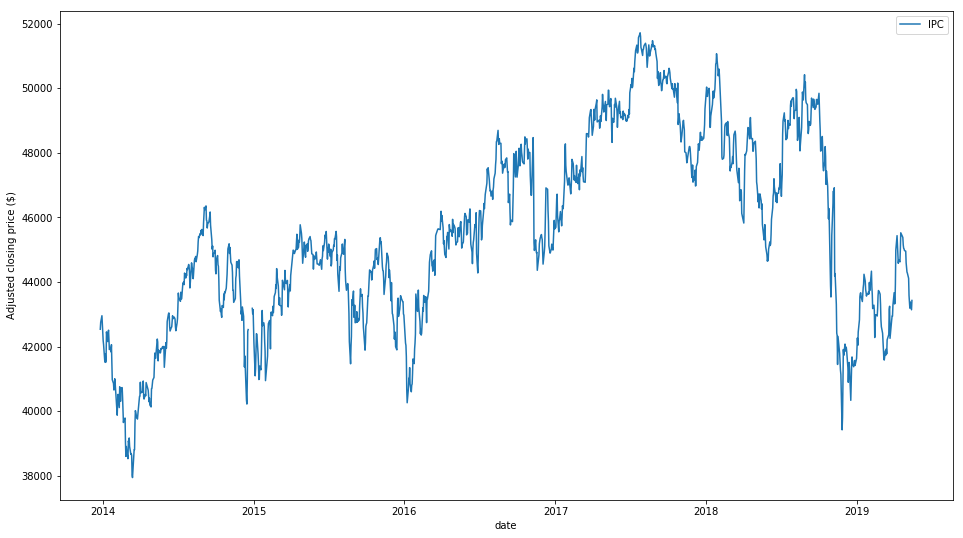

In [4]:
%matplotlib inline

# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(ipc.date, ipc.close, label='IPC')
# ax.plot(short_rolling_msft.index, short_rolling_msft, label='20 days rolling')
# ax.plot(long_rolling_msft.index, long_rolling_msft, label='100 days rolling')

ax.set_xlabel('date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()
plt.show()

### Densidad

Hicimos una función _lag_ con el fin de comporar el cierre de una fecha con la del día anterior, esto de manera porcentual tienen una distribución la cual se observa como sigue.

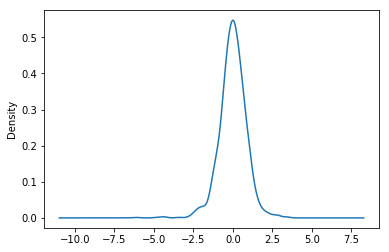

In [5]:
%matplotlib inline
ipc["deltaPct"].plot(kind="density")

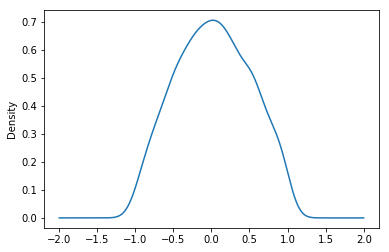

In [6]:
ipc.loc[(ipc.deltaPct >= -1.0) & (ipc.deltaPct <= 1.0), "deltaPct"].plot(kind="density")

Para nuestro análisis de sentimiento y su aprendizaje,
tendremos 3 sentimientos:
    * Negativo (-1): cuando el cambio en el IPC de la BMV sea menor o igual a -0.5% respecto al cierre del día anterior
    * Neutral (0): cuando el cambio en el IPC de la BMV sea mayor a -0.5% y menor a +0.5% respecto al cierre del día anterior
    * Positivo (+1): cuando el cambio en el IPC de la BMV sea mayor o igual a +0.5%
    
Estos números lo tomamos de la distribución de los datos, en los cuales el 25% 

**Nota:** crearemos una columna, la cual tendrá el posible análisis de sentimiento, el cual posteriormente aplicaremos el modelo de Lenguaje Natural, para intentar extraer el sentimiento basado en el comportamiento del día anterior y los tweets que mencionen palabras clave relacionados con la BMV.

Así mismo existen datos faltantes en la información obtenida de Yahoo! Finance. 

In [7]:
ipc.loc[ipc.deltaPct.isna()]

,date,close,volume,deltaPct
0,2013-12-26,42540.320313,139436700.0,NaN
247,2014-12-22,NaN,NaN,NaN
248,2014-12-23,NaN,NaN,NaN
249,2014-12-24,NaN,NaN,NaN
250,2014-12-26,NaN,NaN,NaN
251,2014-12-29,43187.640625,0.0,NaN


In [8]:
ipc.loc[ipc.deltaPct <= -0.5, "sentiment"] = -1
ipc.loc[ipc.deltaPct >= +0.5, "sentiment"] = 1
ipc.loc[ipc.sentiment.isna(), "sentiment"] = 0
ipc.loc[ipc.deltaPct.isna(), "deltaPct"] = 0
ipc.head()

,date,close,volume,deltaPct,sentiment
0,2013-12-26,42540.320313,139436700.0,0.000000,0.0
1,2013-12-27,42753.218750,154856000.0,0.497971,0.0
2,2013-12-30,42958.820313,175830000.0,0.478602,0.0
3,2014-01-02,42188.449219,139707400.0,-1.826024,-1.0
4,2014-01-03,42064.968750,141022700.0,-0.293547,0.0


## Sentiment Analysis

### Extracción y Obtención de Tweets

In [9]:
def extract_tweets(soup, file, i, year, silent=False):
    tweets = soup.find_all("table", attrs={"class": "tweet"})
    # soup.find_all("div", attrs={"class": "tweet-text"})
    # tweet = tweets[0]
    for tweet in tweets:
        tweet_text = tweet.find_all('div', attrs={'class': 'tweet-text'})
        tweet_date = tweet.find_all("td", attrs={'class': 'timestamp'})
        for text in tweet_text:
            if type(text) == bs4.element.Tag:
                txt = re.sub("(eleconomista\.com\.mx|pic\.twitter\.com|bit\.ly|bitly\.com)/[^ ]*", " ", text.text).strip()
                txt = re.sub("(\||\n)", " ", txt)
                file.write(txt + "|")
        for date in tweet_date:
            if type(date) == bs4.element.Tag:
                date = date.text.strip() 
                if re.match("[0-9]*[smh]$", date, re.IGNORECASE) is not None: #detectar si son horas, poner fecha actual
                    date = str(datetime.datetime.now())[0:10] + ' 00:00:00'
                else:
                    if len(date) > 6: #detectamos si es una fecha corta (Mar 18) y que no corte el día
                        date = re.sub(year[-2:] + "$", "", date)
                    date = str(parser.parse(date + " " + year) ) 
                file.write(date + "|%s"%i + "\n")
                

In [10]:
def get_tweets(query="bolsa OR IPC OR BMV", newspaper="elfinanciero_mx", year="2018", filename="file", silent=False):
    q = 'https://mobile.twitter.com/search?q=' + query + \
          '%20from%3A' + newspaper + \
          '%20since%3A'+year+'-01-01%20until%3A'+year+'-12-31&src=typd&lang=en'

    with open("%s.%s.csv"%(filename,year), "wt") as file:
        i = 0
        q = 'https://mobile.twitter.com/search?q=' + query + \
        '%20from%3A' + newspaper + '%20since%3A' + year + \
        '-01-01%20until%3A' + year +'-12-31&src=typd&lang=en'
        file.write("tweet|time|page\n") #header
        while(True): #loop para extraer todas las páginas 
            if silent == False:
                print("  Downloading page %d..."%(i+1))
            try:
                response = requests.get(q)
            except:
                raise Exception("Error al obtener página de resultados.")
            if response.status_code != 200:
                raise Exception("Error (!= 200) al obtener página de resultados.")
            
#             with open("%s_%d.html"%(query,i), 'w') as html:
#                html.write(response.text)
            
            soup = BeautifulSoup(response.text, 'lxml') #abre la primera página de búsqueda de twitter
            extract_tweets(soup, file, i, year)

            nx = soup.find("a", text=" Load older Tweets ")
            if nx != None and nx.has_attr('href'):
                q = "https://mobile.twitter.com" + nx.get_attribute_list('href')[0]
            else:
                break
            i += 1
    if silent == False:
        print("  Done!")

In [11]:
%%time
for yr in ["2014", "2015", "2016", "2017", "2018", "2019"]:
    for source in ["elfinanciero_mx", "eleconomista"]:
        print("Downloading year %s from @%s"%(yr,source))
        get_tweets(query="bolsa OR IPC OR BMV", newspaper=source, year=yr, filename="tweets.raw/bmv.%s"%source)

  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
CPU times: user 11.2 s, sys: 331 ms, total: 11.5 s
Wall time: 1min 20s


### Limpiar columnas

In [12]:
bmv = pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2014.csv", sep="|")
bmv = bmv.append(pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2015.csv", sep="|"))
bmv = bmv.append(pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2016.csv", sep="|"))
bmv = bmv.append(pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2017.csv", sep="|"))
bmv = bmv.append(pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2018.csv", sep="|"))
bmv = bmv.append(pd.read_csv("tweets.raw/bmv.elfinanciero_mx.2019.csv", sep="|"))
bmv["source"] = "elfinanciero_mx"
bmv = bmv.append(pd.read_csv("tweets.raw/bmv.eleconomista.2014.csv", sep="|"))
bmv = bmv.append(pd.read_csv("tweets.raw/bmv.eleconomista.2015.csv", sep="|"))
bmv = bmv.append(pd.read_csv("tweets.raw/bmv.eleconomista.2016.csv", sep="|"))
bmv = bmv.append(pd.read_csv("tweets.raw/bmv.eleconomista.2017.csv", sep="|"))
bmv = bmv.append(pd.read_csv("tweets.raw/bmv.eleconomista.2018.csv", sep="|"))
bmv = bmv.append(pd.read_csv("tweets.raw/bmv.eleconomista.2019.csv", sep="|"))
bmv["source"] = np.where(pd.isna(bmv["source"]), "eleconomista", bmv.source)
bmv.time = pd.to_datetime(bmv.time)
bmv.tweet = bmv.tweet.astype("str")
bmv.source = bmv.source.astype("str")
bmv = bmv.drop(columns=["page"])
bmv.dtypes

/home/jaa6766/.local/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


source            object
time      datetime64[ns]
tweet             object
dtype: object

In [13]:
#ordenar columnas 
bmv = bmv.sort_values(by=["time"])
#reindizar
bmv.index = range(0, bmv.shape[0])
bmv.tail(5)

,source,time,tweet
2462,elfinanciero_mx,2019-05-23,Las principales bolsas del mundo caen por las ...
2463,elfinanciero_mx,2019-05-24,La Bolsa mexicana apunta a interrumpir una rac...
2464,elfinanciero_mx,2019-05-24,#Opinión La @BMVMercados buscará prohibir el u...
2465,elfinanciero_mx,2019-05-24,#ÚLTIMAHORA Comisión de Bolsa y Valores de EU ...
2466,elfinanciero_mx,2019-05-27,"El referencial S&P/BMV IPC bajaba 0.31%, a 42 ..."


In [14]:
bmv.to_csv("bmv.csv.xz", compression="xz", index=False)
bmv.shape

(2467, 3)

In [15]:
bmv = pd.read_csv("bmv.csv.xz", compression="xz")
bmv["time"] = pd.to_datetime(bmv.time)
bmv.head(1)

,source,time,tweet
0,elfinanciero_mx,2014-01-01,#BMV superaría los 46 mil puntos en 2014: Accival


### NLP

De manera experimental realizaremos un entrenamiento con el sentimiento que obtuvimos en el paso anterior (IPC), y lo asignaremos a los valores de la misma fecha del tweet.

In [16]:
bmv.drop(columns=["sentiment"], inplace=True, errors="ignore")
#sentimiento basado en el porcentaje de cambio del ipc
bmv["ipc"] = bmv.join(ipc.set_index("date"), on="time", how="left").deltaPct.round(0)
#sentimiento basado en reglas
bmv["sentiment"] = bmv.join(ipc.set_index("date"), on="time", how="left").sentiment
bmv.head(5)

,source,time,tweet,ipc,sentiment
0,elfinanciero_mx,2014-01-01,#BMV superaría los 46 mil puntos en 2014: Accival,NaN,NaN
1,elfinanciero_mx,2014-01-02,10 ganadoras y 10 perdedoras en la #BMV durant...,-2.0,-1.0
2,elfinanciero_mx,2014-01-02,#Mercados #BMV avanza 0.22% en primer sesión d...,-2.0,-1.0
3,elfinanciero_mx,2014-01-02,#Mercados #BMV cae 1.12% por toma de utilidade...,-2.0,-1.0
4,elfinanciero_mx,2014-01-02,GRÁFICA. ¿Quiénes ganaron y quiénes perdieron ...,-2.0,-1.0


Existen fechas en las cuales no opera la bolsa, pero sí existen tweets publicados; por lo que es conveniente aplicar dicho tweet al cierre de la jornada del siguiente día hábil para la bolsa. Se puede observar en la salida anterior, el caso de un 1 de Enero, donde la bolsa no laboró. Pero el 2 de enero sí, entonces, dicho tweet aplica para el 2 de Enero. 

Lo mismo aplica para tweets que son publicados en Sábado o Domingo, por lo que aplicamos el sentimiento del siguiente día hábil.

In [17]:
def tweet_adjust_df(df, columns=["sentiment", "ipc"], ipc=ipc[["date", "sentiment", "deltaPct"]]):
    """Ajusta el dataframe de tweets con los sentimientos y valor IPC del siguiente día hábil.
    Ojo: el dataframe del IPC deberá conteneter (en orden):
    * fecha: es con lo que hacemos el índice
    * los siguientes valores que coincidan con el parámetro `columns`
    """
    df = df.copy()
    ipc = ipc.copy()
    i = 0
    for col in columns:
        for (idx, row) in df.loc[df[col].isna(), :].iterrows():
            #buscar en las siguientes fechas hábiles, 4 días máx
            dates = [df.loc[idx, "time"] + datetime.timedelta(days=j) for j in range (0,6)]
            dates = ['{0:%Y-%m-%d}'.format(datum) for datum in dates]
            ipc_dates = ipc.loc[ipc.date.isin(dates), ipc.keys()[i+1]].head(1)
        i += 1
    #establecer en sentimiento neutral (0) los que aún así no pudimos determinar el sentimiento
    df.loc[np.any(df.isna(), axis=1), np.any(df.isna(), axis=0)] = 0
    return df
bmv = tweet_adjust_df(bmv, ["ipc", "sentiment"]).copy()
bmv.head(3)

,source,time,tweet,ipc,sentiment
0,elfinanciero_mx,2014-01-01,#BMV superaría los 46 mil puntos en 2014: Accival,0.0,0.0
1,elfinanciero_mx,2014-01-02,10 ganadoras y 10 perdedoras en la #BMV durant...,-2.0,-1.0
2,elfinanciero_mx,2014-01-02,#Mercados #BMV avanza 0.22% en primer sesión d...,-2.0,-1.0


Dado que El Financiero y El Economista publican en español utilizaremos las reglas y raíces de este nuestro idioma.

In [18]:
stop_words = stopwords.words('spanish')
stemmer = nltk.stem.SnowballStemmer('spanish')
non_words = list(punctuation)
non_words.extend(['¿', '¡'])

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed
def tokenize(text):
    text = ''.join([c for c in text if c not in non_words])
    tokens = word_tokenize(text)
    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

### Separación en conjunto de entrenamiento y pruebas

Separamos nuestro data set, con semilla estática, para separa nuestro set en datos de entrenamiento y prueba de manera reproducible.

In [19]:
train, test = train_test_split(bmv, test_size=0.4, random_state=175904)
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)
train = train.copy()
test = test.copy()
print("Tamaño de conjuntos de datos:\nEntrenamiento: %d (%f%%)\nPrueba: %d (%f%%)"%(
    train.shape[0], 100*train.shape[0]/bmv.shape[0], 
    test.shape[0], 100*test.shape[0]/bmv.shape[0]))

Tamaño de conjuntos de datos:
Entrenamiento: 1480 (59.991893%)
Prueba: 987 (40.008107%)


#### Naïve-Bayes

In [20]:
pipe0 = Pipeline([
    ("token", CountVectorizer(tokenizer=tokenize, stop_words=stop_words)),
    ("tfid", TfidfTransformer()),
    ("clf", MultinomialNB(alpha=1.0))
])
pipe0m0 = pipe0.fit(train.tweet, train.sentiment)
pipe0m1 = pipe0.fit(train.tweet, train.ipc)
train["sentiment_hat"] = pipe0m0.predict(train.tweet)
train["ipc_hat"] = pipe0m1.predict(train.tweet)
train.head()

,source,time,tweet,ipc,sentiment,sentiment_hat,ipc_hat
0,elfinanciero_mx,2016-04-03,#Empresas Las 5 ganadoras y 5 perdedoras del 1...,0.0,0.0,0.0,0.0
1,elfinanciero_mx,2015-12-07,#EFMercados Bolsa Mexicana cae 0.8% y liga 4 d...,-1.0,-1.0,0.0,0.0
2,elfinanciero_mx,2016-03-21,EFMercados Acciones de EU operan con ligeras p...,0.0,0.0,0.0,0.0
3,elfinanciero_mx,2014-03-04,En 2013 se registraron dividendos récord en la...,1.0,1.0,0.0,0.0
4,eleconomista,2017-11-27,La salida de José Antonio Meade de la SHCP fre...,-1.0,-1.0,0.0,0.0


#### SVM

In [21]:
pipe0b = Pipeline([
    ("token", CountVectorizer(tokenizer=tokenize, stop_words=stop_words)),
    ("tfid", TfidfTransformer()),
    ("clf", LinearSVC())
])
pipe0bm0 = pipe0b.fit(train.tweet, train.sentiment)
pipe0bm1 = pipe0b.fit(train.tweet, train.ipc)
train["sentiment_hat"] = pipe0bm0.predict(train.tweet)
train["ipc_hat"] = pipe0bm1.predict(train.tweet)
train.head()

,source,time,tweet,ipc,sentiment,sentiment_hat,ipc_hat
0,elfinanciero_mx,2016-04-03,#Empresas Las 5 ganadoras y 5 perdedoras del 1...,0.0,0.0,0.0,0.0
1,elfinanciero_mx,2015-12-07,#EFMercados Bolsa Mexicana cae 0.8% y liga 4 d...,-1.0,-1.0,-1.0,-1.0
2,elfinanciero_mx,2016-03-21,EFMercados Acciones de EU operan con ligeras p...,0.0,0.0,0.0,0.0
3,elfinanciero_mx,2014-03-04,En 2013 se registraron dividendos récord en la...,1.0,1.0,1.0,1.0
4,eleconomista,2017-11-27,La salida de José Antonio Meade de la SHCP fre...,-1.0,-1.0,-1.0,-1.0


### Métricas para Modelo basado en Sentimiento

Basamos nuestro modelo en 2 sentimientos: que sube (+1), neutro (0) y que baja (-1)

#### Naïve-Bayes

In [22]:
test["sentiment_hat"] = pipe0m0.predict(test.tweet)
print(classification_report(test.sentiment, test.sentiment_hat))

             precision    recall  f1-score   support

       -1.0       0.33      0.00      0.01       219
        0.0       0.54      0.99      0.70       527
        1.0       0.31      0.02      0.03       241

avg / total       0.44      0.53      0.38       987



#### SVM

In [23]:
test["sentiment_hat"] = pipe0bm0.predict(test.tweet)
print(classification_report(test.sentiment, test.sentiment_hat))

             precision    recall  f1-score   support

       -4.0       0.00      0.00      0.00         0
       -2.0       0.00      0.00      0.00         0
       -1.0       0.34      0.25      0.29       219
        0.0       0.57      0.65      0.61       527
        1.0       0.37      0.32      0.34       241
        2.0       0.00      0.00      0.00         0
        3.0       0.00      0.00      0.00         0

avg / total       0.47      0.48      0.47       987



/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Métricas para Modelo Basado en el IPC

Basamos nuestro modelo en el porcentaje de cambio, sin decimales. En más de 4 años ha habido movimiento entre el -6% y el 3%.

In [24]:
ipc.deltaPct.describe()

count    1349.000000
mean       -0.003199
std         0.849959
min        -6.171380
25%        -0.461375
50%         0.014004
75%         0.508979
max         3.463701
Name: deltaPct, dtype: float64

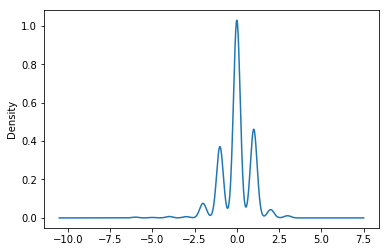

In [25]:
bmv.ipc.plot(kind="density")

#### Naïve-Bayes

In [26]:
test["ipc_hat"] = pipe0m1.predict(test.tweet)
print(classification_report(test.ipc, test.ipc_hat))

             precision    recall  f1-score   support

       -6.0       0.00      0.00      0.00         3
       -5.0       0.00      0.00      0.00         1
       -4.0       0.00      0.00      0.00         4
       -3.0       0.00      0.00      0.00         3
       -2.0       0.00      0.00      0.00        42
       -1.0       0.00      0.00      0.00       166
        0.0       0.54      0.99      0.70       527
        1.0       0.31      0.02      0.03       219
        2.0       0.00      0.00      0.00        17
        3.0       0.00      0.00      0.00         5

avg / total       0.35      0.53      0.38       987



/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### SVM

In [27]:
test["ipc_hat"] = pipe0bm1.predict(test.tweet)
print(classification_report(test.ipc, test.ipc_hat))

             precision    recall  f1-score   support

       -6.0       0.00      0.00      0.00         3
       -5.0       0.00      0.00      0.00         1
       -4.0       1.00      0.25      0.40         4
       -3.0       0.00      0.00      0.00         3
       -2.0       0.29      0.05      0.08        42
       -1.0       0.25      0.24      0.24       166
        0.0       0.57      0.65      0.61       527
        1.0       0.34      0.33      0.33       219
        2.0       0.25      0.06      0.10        17
        3.0       0.00      0.00      0.00         5

avg / total       0.44      0.47      0.45       987



/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Tweets de Tasas de Interés

Dado que aún nuestro mejor resultado en nuestro modelo pasado, vamos a intentar utilizar otros términos de búsqueda: Tasas de Interés, Bonos y Cetes

In [28]:
%%time
for yr in ["2014", "2015", "2016", "2017", "2018", "2019"]:
    for source in ["elfinanciero_mx", "eleconomista"]:
        print("Downloading year %s from @%s"%(yr,source))
        get_tweets(query='"tasas de interés" OR cetes OR bonos', newspaper=source, year=yr, filename="tweets.raw/cetes.%s"%source, silent=False)

  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
  Done!
CPU times: user 3.91 s, sys: 109 ms, total: 4.02 s
Wall time: 31.7 s


In [29]:
cetes = pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2014.csv", sep="|")
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2015.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2016.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2017.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2018.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.elfinanciero_mx.2019.csv", sep="|"))
cetes["source"] = "elfinanciero_mx"
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2014.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2015.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2016.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2017.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2018.csv", sep="|"))
cetes = cetes.append(pd.read_csv("tweets.raw/cetes.eleconomista.2019.csv", sep="|"))
cetes["source"] = np.where(pd.isna(cetes["source"]), "eleconomista", cetes.source)
cetes.time = pd.to_datetime(cetes.time)
cetes.tweet = cetes.tweet.astype("str")
cetes.source = cetes.source.astype("str")
cetes = cetes.drop(columns=["page"])
cetes.dtypes

/home/jaa6766/.local/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


source            object
time      datetime64[ns]
tweet             object
dtype: object

In [30]:
#ordenar columnas 
cetes = cetes.sort_values(by=["time"])
#reindizar
cetes.index = range(0, cetes.shape[0])
cetes.tail(5)

,source,time,tweet
828,elfinanciero_mx,2019-05-21,La empresa destacó que la colocación fue a un ...
829,elfinanciero_mx,2019-05-21,#Opinión En la actualidad las economías siguen...
830,elfinanciero_mx,2019-05-23,#Opinión México enfrenta tasas de interés muy ...
831,eleconomista,2019-05-24,¿Qué factores podrían cambiar la situación del...
832,eleconomista,2019-05-27,"A 10 meses de iniciar operaciones, la Biva sup..."


In [31]:
cetes.to_csv("cetes.csv.xz", compression="xz", index=False)
cetes.shape

(833, 3)

In [32]:
cetes = pd.read_csv("cetes.csv.xz", compression="xz")
cetes["time"] = pd.to_datetime(cetes.time)
cetes.head(1)

,source,time,tweet
0,eleconomista,2014-01-01,#Podcast Qué es y cómo funciona el programa ...


In [33]:
cetes.drop(columns=["sentiment"], inplace=True, errors="ignore")
#sentimiento basado en el porcentaje de cambio del ipc
cetes["ipc"] = cetes.join(ipc.set_index("date"), on="time", how="left").deltaPct.round(0)
#sentimiento basado en reglas
cetes["sentiment"] = cetes.join(ipc.set_index("date"), on="time", how="left").sentiment
cetes.head(5)

,source,time,tweet,ipc,sentiment
0,eleconomista,2014-01-01,#Podcast Qué es y cómo funciona el programa ...,NaN,NaN
1,eleconomista,2014-01-07,Tasa líder de #Cetes sube a 3.17% ow.ly/smiWM,1.0,1.0
2,elfinanciero_mx,2014-01-07,Tasas de interés mixtas en subasta primaria de...,1.0,1.0
3,eleconomista,2014-01-09,#Bonos M con presiones al alza en corto plazo:...,0.0,0.0
4,elfinanciero_mx,2014-01-13,@FEMSA colocó una reapertura de sus bonos a 10...,-1.0,-1.0


Como en el caso anterior, existen fechas en las cuales no opera la bolsa, pero sí existen tweets publicados; por lo que es conveniente aplicar dicho tweet al cierre de la jornada del siguiente día hábil para la bolsa. Se puede observar en la salida anterior, el caso de un 1 de Enero, donde la bolsa no laboró. Pero el 2 de enero sí, entonces, dicho tweet aplica para el 2 de Enero. 

Lo mismo aplica para tweets que son publicados en Sábado o Domingo, por lo que aplicamos el sentimiento del siguiente día hábil.

In [34]:
cetes = tweet_adjust_df(cetes, ["ipc", "sentiment"], ipc[["date", "deltaPct", "sentiment"]]).copy()
cetes.tail()

,source,time,tweet,ipc,sentiment
828,elfinanciero_mx,2019-05-21,La empresa destacó que la colocación fue a un ...,0.0,0.0
829,elfinanciero_mx,2019-05-21,#Opinión En la actualidad las economías siguen...,0.0,0.0
830,elfinanciero_mx,2019-05-23,#Opinión México enfrenta tasas de interés muy ...,0.0,0.0
831,eleconomista,2019-05-24,¿Qué factores podrían cambiar la situación del...,0.0,0.0
832,eleconomista,2019-05-27,"A 10 meses de iniciar operaciones, la Biva sup...",0.0,0.0


### Separación en conjunto de entrenamiento y pruebas

Separamos nuestro data set, con semilla estática, para separa nuestro set en datos de entrenamiento y prueba de manera reproducible.

In [35]:
train2, test2 = train_test_split(cetes, test_size=0.4, random_state=175904)
train2.reset_index(drop=True,inplace=True)
test2.reset_index(drop=True,inplace=True)
train2 = train2.copy()
test2 = test2.copy()
print("Tamaño de conjuntos de datos:\nEntrenamiento: %d (%f%%)\nPrueba: %d (%f%%)"%(
    train2.shape[0], 100*train2.shape[0]/cetes.shape[0], 
    test2.shape[0], 100*test2.shape[0]/cetes.shape[0]))

Tamaño de conjuntos de datos:
Entrenamiento: 499 (59.903962%)
Prueba: 334 (40.096038%)


#### Naïve-Bayes

In [36]:
pipe1 = Pipeline([
    ("token", CountVectorizer(tokenizer=tokenize, stop_words=stop_words)),
    ("tfid", TfidfTransformer()),
    ("clf", MultinomialNB(alpha=1.0))
])
pipe1m0 = pipe1.fit(train2.tweet, train2.sentiment)
pipe1m1 = pipe1.fit(train2.tweet, train2.ipc)
train2["sentiment_hat"] = pipe1m0.predict(train2.tweet)
train2["ipc_hat"] = pipe1m1.predict(train2.tweet)
train2.head()

,source,time,tweet,ipc,sentiment,sentiment_hat,ipc_hat
0,eleconomista,2018-08-06,"#Entérate: HSBC, Credit Suisse, Barclays y Deu...",0.0,0.0,0.0,0.0
1,elfinanciero_mx,2019-01-19,#BWMX Si @lopezobrador_ logra convencer a los ...,0.0,0.0,0.0,0.0
2,eleconomista,2015-04-23,Analizan emitir bonos para que los mexicanos i...,0.0,0.0,0.0,0.0
3,eleconomista,2016-09-30,¡Buen viernes! #EnPortada: Banxico subió sus t...,-1.0,-1.0,0.0,0.0
4,elfinanciero_mx,2015-12-11,#Opinión ¿Cuánto subirán las tasas de interés ...,-1.0,-1.0,0.0,0.0


#### SVM

In [37]:
pipe1b = Pipeline([
    ("token", CountVectorizer(tokenizer=tokenize, stop_words=stop_words)),
    ("tfid", TfidfTransformer()),
    ("clf", LinearSVC())
])
pipe1bm0 = pipe1.fit(train2.tweet, train2.sentiment)
pipe1bm1 = pipe1.fit(train2.tweet, train2.ipc)
train2["sentiment_hat"] = pipe1bm0.predict(train2.tweet)
train2["ipc_hat"] = pipe1bm1.predict(train2.tweet)
train2.head()

,source,time,tweet,ipc,sentiment,sentiment_hat,ipc_hat
0,eleconomista,2018-08-06,"#Entérate: HSBC, Credit Suisse, Barclays y Deu...",0.0,0.0,0.0,0.0
1,elfinanciero_mx,2019-01-19,#BWMX Si @lopezobrador_ logra convencer a los ...,0.0,0.0,0.0,0.0
2,eleconomista,2015-04-23,Analizan emitir bonos para que los mexicanos i...,0.0,0.0,0.0,0.0
3,eleconomista,2016-09-30,¡Buen viernes! #EnPortada: Banxico subió sus t...,-1.0,-1.0,0.0,0.0
4,elfinanciero_mx,2015-12-11,#Opinión ¿Cuánto subirán las tasas de interés ...,-1.0,-1.0,0.0,0.0


### Métricas para Modelo basado en Sentimiento

Basamos nuestro modelo en 2 sentimientos: que sube (+1), neutro (0) y que baja (-1)

#### Naïve-Bayes

In [38]:
test2["sentiment_hat"] = pipe1m0.predict(test2.tweet)
print(classification_report(test2.sentiment, test2.sentiment_hat))

             precision    recall  f1-score   support

       -1.0       1.00      0.03      0.05        79
        0.0       0.50      0.99      0.67       167
        1.0       0.50      0.01      0.02        88

avg / total       0.62      0.51      0.35       334



#### SVM

In [39]:
test2["sentiment_hat"] = pipe1bm0.predict(test2.tweet)
print(classification_report(test2.sentiment, test2.sentiment_hat))

             precision    recall  f1-score   support

       -1.0       1.00      0.03      0.05        79
        0.0       0.50      0.99      0.67       167
        1.0       0.50      0.01      0.02        88

avg / total       0.62      0.51      0.35       334



### Métricas para Modelo Basado en el IPC

#### Naïve-Bayes

In [40]:
test2["ipc_hat"] = pipe1m1.predict(test2.tweet)
print(classification_report(test2.ipc, test2.ipc_hat))

             precision    recall  f1-score   support

       -4.0       0.00      0.00      0.00         1
       -3.0       0.00      0.00      0.00         1
       -2.0       0.00      0.00      0.00        10
       -1.0       1.00      0.03      0.06        67
       -0.0       0.50      0.99      0.67       167
        1.0       0.50      0.01      0.02        81
        2.0       0.00      0.00      0.00         7

avg / total       0.57      0.51      0.35       334



/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### SVM

In [41]:
test2["ipc_hat"] = pipe1bm1.predict(test2.tweet)
print(classification_report(test2.ipc, test2.ipc_hat))

             precision    recall  f1-score   support

       -4.0       0.00      0.00      0.00         1
       -3.0       0.00      0.00      0.00         1
       -2.0       0.00      0.00      0.00        10
       -1.0       1.00      0.03      0.06        67
       -0.0       0.50      0.99      0.67       167
        1.0       0.50      0.01      0.02        81
        2.0       0.00      0.00      0.00         7

avg / total       0.57      0.51      0.35       334



/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Tweets de Divisas

Dado que aún nuestro mejor resultado en nuestro modelo pasado, vamos a intentar utilizar otros términos de búsqueda: peso, divisa, Dólar, Euro, Libra.

In [ ]:
%%time
for yr in ["2014", "2015", "2016", "2017", "2018", "2019"]:
    for source in ["elfinanciero_mx", "eleconomista"]:
        print("Downloading year %s from @%s"%(yr,source))
        get_tweets(query='peso OR divisa OR dollar OR dolar OR usd OR euro OR libra',
                   newspaper=source, year=yr, filename="tweets.raw/forex.%s"%source, silent=False)

In [43]:
forex = pd.read_csv("tweets.raw/forex.elfinanciero_mx.2014.csv", sep="|")
forex = forex.append(pd.read_csv("tweets.raw/forex.elfinanciero_mx.2015.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.elfinanciero_mx.2016.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.elfinanciero_mx.2017.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.elfinanciero_mx.2018.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.elfinanciero_mx.2019.csv", sep="|"))
forex["source"] = "elfinanciero_mx"
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2014.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2015.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2016.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2017.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2018.csv", sep="|"))
forex = forex.append(pd.read_csv("tweets.raw/forex.eleconomista.2019.csv", sep="|"))
forex["source"] = np.where(pd.isna(forex["source"]), "eleconomista", forex.source)
forex.time = pd.to_datetime(forex.time)
forex.tweet = forex.tweet.astype("str")
forex.source = forex.source.astype("str")
forex = forex.drop(columns=["page"])
forex.dtypes

/home/jaa6766/.local/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


source            object
time      datetime64[ns]
tweet             object
dtype: object

In [44]:
#ordenar columnas 
forex = forex.sort_values(by=["time"])
#reindizar
forex.index = range(0, forex.shape[0])

forex.tail(5)

,source,time,tweet
3332,eleconomista,2019-03-22,¿Qué le ha favorecido al peso este año? #ElEco...
3333,eleconomista,2019-03-22,El avance del dólar contra el #peso se present...
3334,elfinanciero_mx,2019-03-22,El dólar se dispara a 19.40 pesos en bancos.
3335,elfinanciero_mx,2019-03-22,Plazas europeas caen 'golpeados' por malos dat...
3336,eleconomista,2019-03-24,La moneda mexicana se mantiene como un activo ...


In [45]:
forex.to_csv("forex.csv.xz", compression="xz", index=False)
forex.shape

(3337, 3)

In [46]:
forex = pd.read_csv("forex.csv.xz", compression="xz")
forex["time"] = pd.to_datetime(forex.time)
forex.head(1)

,source,time,tweet
0,elfinanciero_mx,2014-01-01,"#Letonia adopta el euro, se convierte en el pa..."


In [47]:
forex.drop(columns=["sentiment"], inplace=True, errors="ignore")
#sentimiento basado en el porcentaje de cambio del ipc
forex["ipc"] = forex.join(ipc.set_index("date"), on="time", how="left").deltaPct.round(0)
#sentimiento basado en reglas
forex["sentiment"] = forex.join(ipc.set_index("date"), on="time", how="left").sentiment
forex.head(5)

,source,time,tweet,ipc,sentiment
0,elfinanciero_mx,2014-01-01,"#Letonia adopta el euro, se convierte en el pa...",NaN,NaN
1,elfinanciero_mx,2014-01-01,#Sitelopediste Peso con mejor desempeño en Lat...,NaN,NaN
2,elfinanciero_mx,2014-01-01,#Dólar se vende dólar a 13.25 pesos en promedi...,NaN,NaN
3,elfinanciero_mx,2014-01-02,#Opinión: @adriantrejo platica cómo el goberna...,-2.0,-1.0
4,elfinanciero_mx,2014-01-03,"#Opinión En LA DIVISA DEL PODER, @adriantrejo ...",-0.0,0.0


Como en el caso anterior, existen fechas en las cuales no opera la bolsa, pero sí existen tweets publicados; por lo que es conveniente aplicar dicho tweet al cierre de la jornada del siguiente día hábil para la bolsa. Se puede observar en la salida anterior, el caso de un 1 de Enero, donde la bolsa no laboró. Pero el 2 de enero sí, entonces, dicho tweet aplica para el 2 de Enero. 

Lo mismo aplica para tweets que son publicados en Sábado o Domingo, por lo que aplicamos el sentimiento del siguiente día hábil.

In [48]:
forex = tweet_adjust_df(forex, ["ipc", "sentiment"], ipc=ipc[["date", "deltaPct", "sentiment"]]).copy()
forex.tail(3)

,source,time,tweet,ipc,sentiment
3334,elfinanciero_mx,2019-03-22,El dólar se dispara a 19.40 pesos en bancos.,-2.0,-1.0
3335,elfinanciero_mx,2019-03-22,Plazas europeas caen 'golpeados' por malos dat...,-2.0,-1.0
3336,eleconomista,2019-03-24,La moneda mexicana se mantiene como un activo ...,0.0,0.0


### Separación en conjunto de entrenamiento y pruebas

Separamos nuestro data set, con semilla estática, para separa nuestro set en datos de entrenamiento y prueba de manera reproducible.

In [49]:
train3, test3 = train_test_split(forex, test_size=0.4, random_state=175904)
train3.reset_index(drop=True,inplace=True)
test3.reset_index(drop=True,inplace=True)
train3 = train3.copy()
test3 = test3.copy()
print("Tamaño de conjuntos de datos:\nEntrenamiento: %d (%f%%)\nPrueba: %d (%f%%)"%(
    train3.shape[0], 100*train3.shape[0]/forex.shape[0], 
    test3.shape[0], 100*test3.shape[0]/forex.shape[0]))

Tamaño de conjuntos de datos:
Entrenamiento: 2002 (59.994007%)
Prueba: 1335 (40.005993%)


#### Naïve-Bayes

In [50]:
pipe2 = Pipeline([
    ("token", CountVectorizer(tokenizer=tokenize, stop_words=stop_words)),
    ("tfid", TfidfTransformer()),
    ("clf", MultinomialNB(alpha=1.0))
])
pipe2m0 = pipe2.fit(train3.tweet, train3.sentiment)
pipe2m1 = pipe2.fit(train3.tweet, train3.ipc)
train3["sentiment_hat"] = pipe2m0.predict(train3.tweet)
train3["ipc_hat"] = pipe2m1.predict(train3.tweet)
train3.head()

,source,time,tweet,ipc,sentiment,sentiment_hat,ipc_hat
0,elfinanciero_mx,2014-05-12,#LoMásLeído: ¿Por qué el dólar se ha debilitad...,1.0,1.0,0.0,0.0
1,elfinanciero_mx,2016-11-03,Un nuevo análisis prevé que el dólar llegue a ...,-1.0,-1.0,0.0,0.0
2,elfinanciero_mx,2017-06-29,Al peso le 'llueve' y es la peor moneda del mu...,-0.0,0.0,0.0,0.0
3,elfinanciero_mx,2016-02-25,Peso avanza impulsado por datos económicos en EU,2.0,1.0,0.0,0.0
4,eleconomista,2016-07-21,Peso pierde por tercer jornada; dólar subió a ...,-0.0,0.0,0.0,0.0


#### SVM

In [51]:
pipe2b = Pipeline([
    ("token", CountVectorizer(tokenizer=tokenize, stop_words=stop_words)),
    ("tfid", TfidfTransformer()),
    ("clf", LinearSVC())
])
pipe2bm0 = pipe2b.fit(train3.tweet, train3.sentiment)
pipe2bm1 = pipe2b.fit(train3.tweet, train3.ipc)
train3["sentiment_hat"] = pipe2bm0.predict(train3.tweet)
train3["ipc_hat"] = pipe2bm1.predict(train3.tweet)
train3.head()

,source,time,tweet,ipc,sentiment,sentiment_hat,ipc_hat
0,elfinanciero_mx,2014-05-12,#LoMásLeído: ¿Por qué el dólar se ha debilitad...,1.0,1.0,0.0,0.0
1,elfinanciero_mx,2016-11-03,Un nuevo análisis prevé que el dólar llegue a ...,-1.0,-1.0,-1.0,-1.0
2,elfinanciero_mx,2017-06-29,Al peso le 'llueve' y es la peor moneda del mu...,-0.0,0.0,0.0,0.0
3,elfinanciero_mx,2016-02-25,Peso avanza impulsado por datos económicos en EU,2.0,1.0,0.0,0.0
4,eleconomista,2016-07-21,Peso pierde por tercer jornada; dólar subió a ...,-0.0,0.0,0.0,0.0


### Métricas para Modelo basado en Sentimiento

Basamos nuestro modelo en 2 sentimientos: que sube (+1), neutro (0) y que baja (-1)

#### Naïve-Bayes

In [52]:
test3["sentiment_hat"] = pipe2m0.predict(test3.tweet)
print(classification_report(test3.sentiment, test3.sentiment_hat))

             precision    recall  f1-score   support

       -1.0       1.00      0.00      0.01       326
        0.0       0.50      0.99      0.67       673
        1.0       0.44      0.01      0.02       336

avg / total       0.61      0.50      0.34      1335



#### SVM

In [53]:
test3["sentiment_hat"] = pipe2bm0.predict(test3.tweet)
print(classification_report(test3.sentiment, test3.sentiment_hat))

             precision    recall  f1-score   support

       -5.0       0.00      0.00      0.00         0
       -3.0       0.00      0.00      0.00         0
       -2.0       0.00      0.00      0.00         0
       -1.0       0.29      0.14      0.19       326
        0.0       0.51      0.68      0.58       673
        1.0       0.26      0.22      0.24       336

avg / total       0.40      0.43      0.40      1335



/opt/intel/intelpython3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Bibliografía

* Sasaki, Y. (2007). ["The truth of the F-measure"](http://www.toyota-ti.ac.jp/Lab/Denshi/COIN/people/yutaka.sasaki/F-measure-YS-26Oct07.pdf)
* Smetanin, Sergey (2018). ["Sentiment Analysis of Tweets using Multinomial Naive Bayes"](https://towardsdatascience.com/sentiment-analysis-of-tweets-using-multinomial-naive-bayes-1009ed24276b)
* Bird, Steven; Tan,  Liling; et al. [Sentiment Analysis](http://www.nltk.org/howto/sentiment.html)
* Paul, Sayak (2018). [Simplifying Sentiment Analysis in Python](https://www.datacamp.com/community/tutorials/simplifying-sentiment-analysis-python)
* Nagy, Peter (2017). [Python NLTK sentiment analysis](https://www.kaggle.com/ngyptr/python-nltk-sentiment-analysis)
* Garrido, Manuel (2015). [Como hacer Análisis de Sentimiento en español](https://www.pybonacci.org/2015/11/24/como-hacer-analisis-de-sentimiento-en-espanol-2/)
* Bedi, Gunjit (2018). [A guide to Text Classification(NLP) using SVM and Naive Bayes with Python](https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34)